In [30]:
import numpy as np
import os
import pandas as pd
from scipy.io import loadmat

import matplotlib.pyplot as plt

from scipy import signal

from mne.time_frequency import psd_array_multitaper

## Dataset import

In [31]:
# Dicionário para armazenar os dados
original = {}

# Path para o file com os dados
directory = "Data_trials"

# Iterar através de cada pasta de participante
for participant_folder in os.listdir(directory):
    participant_path = os.path.join(directory, participant_folder)
    if os.path.isdir(participant_path):
        participant_number = participant_folder[1:]  # Extrair número do participante do nome da pasta

        # Iterar através dos arquivos MATLAB na pasta do participante
        for file_name in os.listdir(participant_path):
            if file_name.endswith(".mat"):
                file_path = os.path.join(participant_path, file_name)

                # Carregar arquivo MATLAB
                mat_data = loadmat(file_path)

                # Selecionar a key com o nome do file
                keys = mat_data.keys()
                key = list(keys)[3]

                # Criar DataFrame a partir dos dados; .T para transformar linhas em colunas
                df = pd.DataFrame(mat_data[key].T, columns=['TimeStamps','PO3', 'POz', 'PO4', 'O1', 'Oz', 'O2'])

                # Adicionar os dados ao dicionário usando o nome da variável como chave
                if key not in original:
                    original[key] = []
                original[key].append(df)

print(original)

{'P01_T1_R1_1': [      TimeStamps        PO3        POz        PO4        O1         Oz  \
0     123.593750   1.864631  -2.860328   1.653587 -6.425547  -3.635653   
1     123.595703   2.416753  -1.077843   2.950483 -4.994550  -1.967141   
2     123.597656   4.313347   1.916548   6.916747 -2.751511   0.732784   
3     123.599609   6.163780   4.130209  10.570951 -1.644686   2.028786   
4     123.601562   6.490129   4.432967  11.097349 -2.291279   1.016683   
...          ...        ...        ...        ...       ...        ...   
2555  128.583984  -8.472112 -14.553066  -4.899053 -3.590019  -4.270864   
2556  128.585938 -10.756668 -17.010790  -7.277852 -7.278764  -7.616994   
2557  128.587891 -12.720378 -18.316055  -9.205285 -9.548800 -10.001910   
2558  128.589844 -11.026507 -16.585035  -8.335190 -8.101057  -8.968301   
2559  128.591797  -6.623455 -12.930046  -5.479271 -4.359848  -5.893701   

            O2  
0     4.468567  
1     5.550319  
2     7.454867  
3     8.273323  
4     7.0

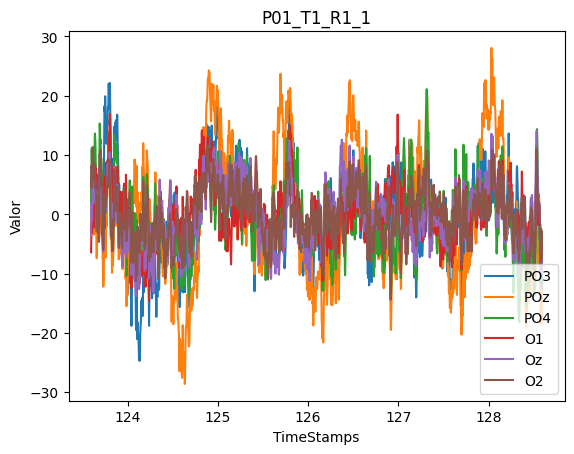

In [32]:
# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in original.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}')
        for data in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for channel in data.columns[1:]:
                plt.plot(data[data.columns[0]], data[channel], label=channel)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()

In [33]:
# Cálculo da frequência de amostragem

data = original['P01_T1_R1_1'][0]

time_diff = data['TimeStamps'].diff().mean()

fs = 1 / time_diff

print("Sampling frequency =", fs, "Hz")

Sampling frequency = 512.0 Hz


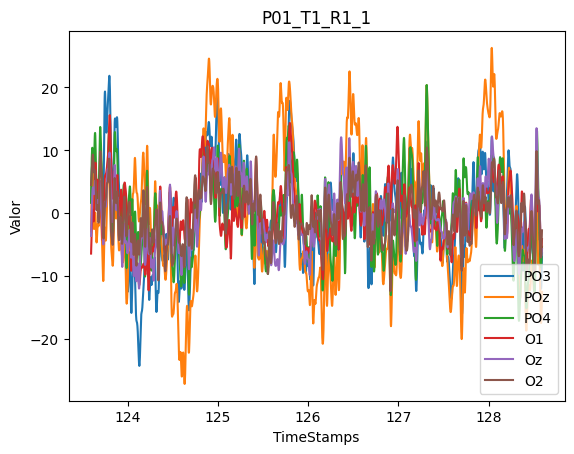

In [34]:
# Definição dos parâmetros do lowpass filter
sos = signal.iirfilter(8, 40, btype='lowpass', analog=False, ftype='butter', fs=fs, output='sos')

#Aplicação de um notch filter para remover frequências de 50 Hz (ruído)
notch_freq = 50.0 
quality_factor = 20.0

b_notch, a_notch = signal.iirnotch(notch_freq, quality_factor, fs)

#Dataframe com os dados filtrados
filtrado= {}

#Aplicação do low pass filter
for key, dfs in original.items():
    filtrado[key] = []
    for df in dfs:
        timestamps = df['TimeStamps']
        df_without_timestamps = df.drop(columns=['TimeStamps'])
        df_filtrado = pd.DataFrame(signal.sosfiltfilt(sos, df_without_timestamps.values, axis=0), columns=df_without_timestamps.columns)
        df_filtrado = pd.concat([timestamps, df_filtrado], axis=1)
        filtrado[key].append(df_filtrado)

#Aplicação do notch filter
for key, dfs in filtrado.items():
    for df in dfs:
        for column in df.columns[1:]:
            df[column] = signal.filtfilt(b_notch, a_notch, df[column])


# Plotar gráficos relativos apenas um gráfico do ensaio 1 do teste 1 do paciente 1
for key, dfs in filtrado.items():
    if key == "P01_T1_R1_1":
        plt.title(f'{key}')
        for data in dfs:
            # Plotar cada estado (relativa a cada coluna)
            for channel in data.columns[1:]:
                plt.plot(data[data.columns[0]], data[channel], label=channel)
        plt.xlabel('TimeStamps')
        plt.ylabel('Valor')
        plt.legend()
        plt.show()


### PSD

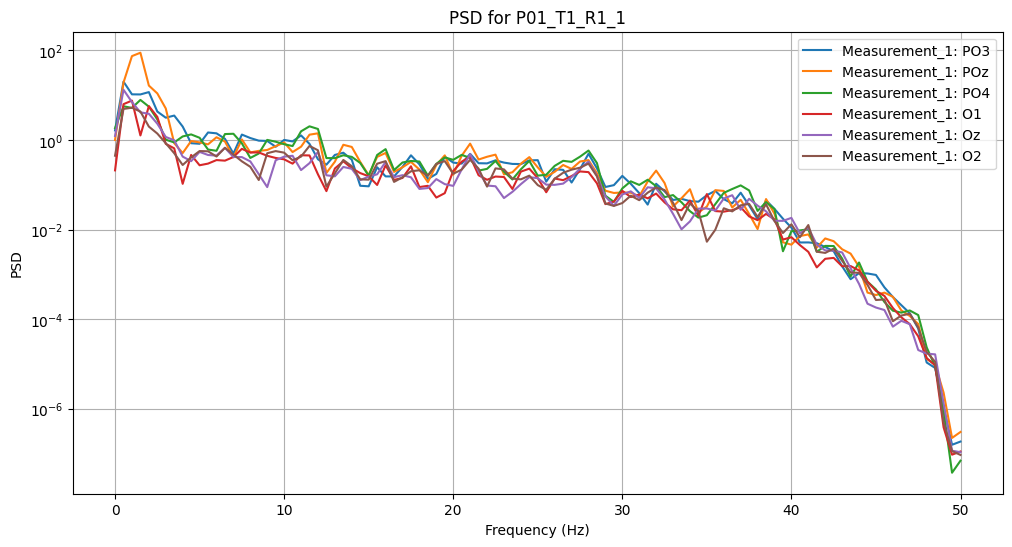

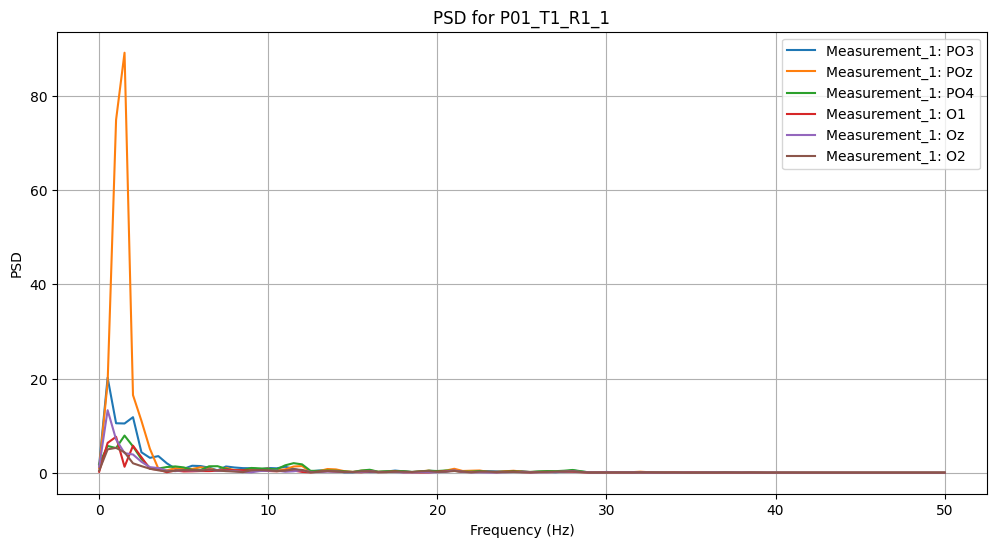

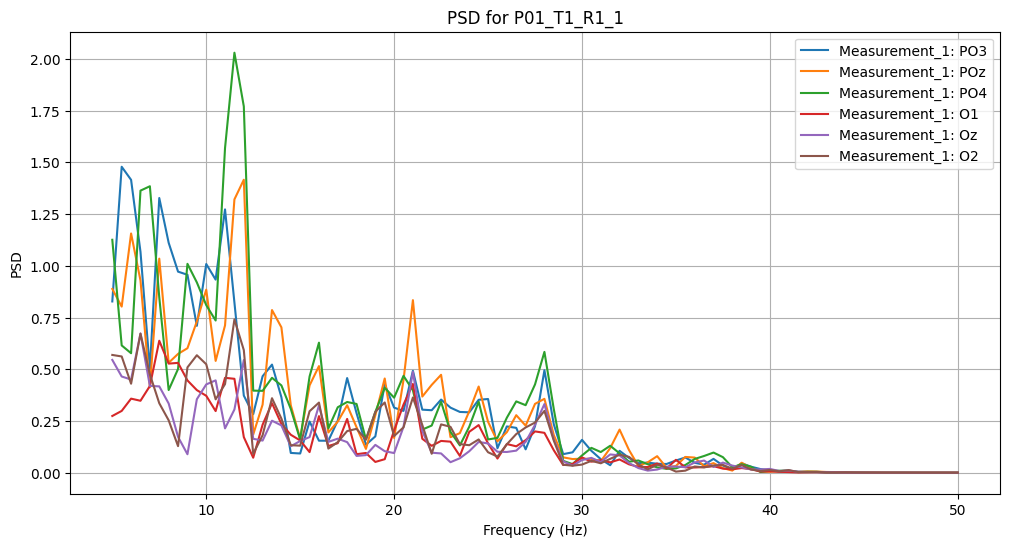

In [43]:
import numpy as np
from scipy import signal

# Function to compute PSD for each channel separately
def compute_psd(data, fs):
    psd_data = {}
    for channel in data.columns[1:]:
        freqs, psd = signal.welch(data[channel], fs=fs, nperseg=fs*2)
        psd_data[channel] = (freqs, psd)
    return psd_data

# Dictionary to store PSD data
psd_results = {}

# Sampling frequency (assuming it's defined somewhere in your code)
fs = 512  # Adjust this according to your actual sampling frequency

# Compute PSD for each trial
for key, dfs in filtrado.items():
    psd_results[key] = {}
    for idx, df in enumerate(dfs):
        psd_results[key][f'Measurement_{idx+1}'] = compute_psd(df, fs)

# Plot PSD for each channel separately
for key, psd_data in psd_results.items():
    if key == "P01_T1_R1_1":  # Adjust the condition as needed
        plt.figure(figsize=(12, 6))
        plt.title(f'PSD for {key}')
        for measurement, channels in psd_data.items():
            for channel, (freqs, psd) in channels.items():
                # Exclude frequencies above 50 Hz
                freqs_filtered = freqs[freqs <= 50]
                psd_filtered = psd[:len(freqs_filtered)]
                plt.semilogy(freqs_filtered, psd_filtered, label=f'{measurement}: {channel}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()
        plt.grid(True)
        plt.show()

# # Plot PSD for each channel separately
# for key, psd_data in psd_results.items():
#     if key == "P01_T1_R1_1":  # Adjust the condition as needed
#         plt.figure(figsize=(12, 6))
#         plt.title(f'PSD for {key}')
#         for measurement, channels in psd_data.items():
#             for channel, (freqs, psd) in channels.items():
#                 # Exclude frequencies above 50 Hz
#                 freqs_filtered = freqs[freqs <= 50]
#                 psd_filtered = psd[:len(freqs_filtered)]
#                 # Convert PSD to a linear scale (0 to 100)
#                 psd_linear = 100 * (psd_filtered / np.max(psd_filtered))
#                 plt.plot(freqs_filtered, psd_linear, label=f'{measurement}: {channel}')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('PSD (0-100 scale)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# Plot PSD for each channel separately
for key, psd_data in psd_results.items():
    if key == "P01_T1_R1_1":  # Adjust the condition as needed
        plt.figure(figsize=(12, 6))
        plt.title(f'PSD for {key}')
        for measurement, channels in psd_data.items():
            for channel, (freqs, psd) in channels.items():
                # Exclude frequencies above 50 Hz
                freqs_filtered = freqs[ (freqs <= 50)]
                psd_filtered = psd[:len(freqs_filtered)]
                plt.plot(freqs_filtered, psd_filtered, label=f'{measurement}: {channel}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()
        plt.grid(True)
        plt.show()

# Plot PSD for each channel separately
for key, psd_data in psd_results.items():
    if key == "P01_T1_R1_1":  # Adjust the condition as needed
        plt.figure(figsize=(12, 6))
        plt.title(f'PSD for {key}')
        for measurement, channels in psd_data.items():
            for channel, (freqs, psd) in channels.items():
                # Exclude frequencies above 50 Hz
                freqs_filtered = freqs[(freqs >= 5) & (freqs <= 50)]
                psd_filtered = psd[(freqs >= 5) & (freqs <= 50)]
                plt.plot(freqs_filtered, psd_filtered, label=f'{measurement}: {channel}')
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.legend()
        plt.grid(True)
        plt.show()



## PSD Combined

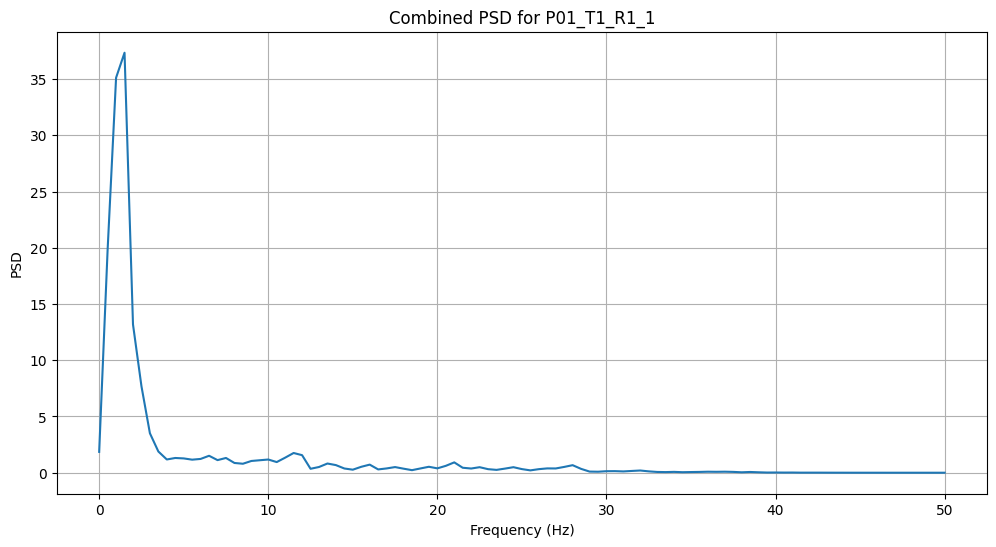

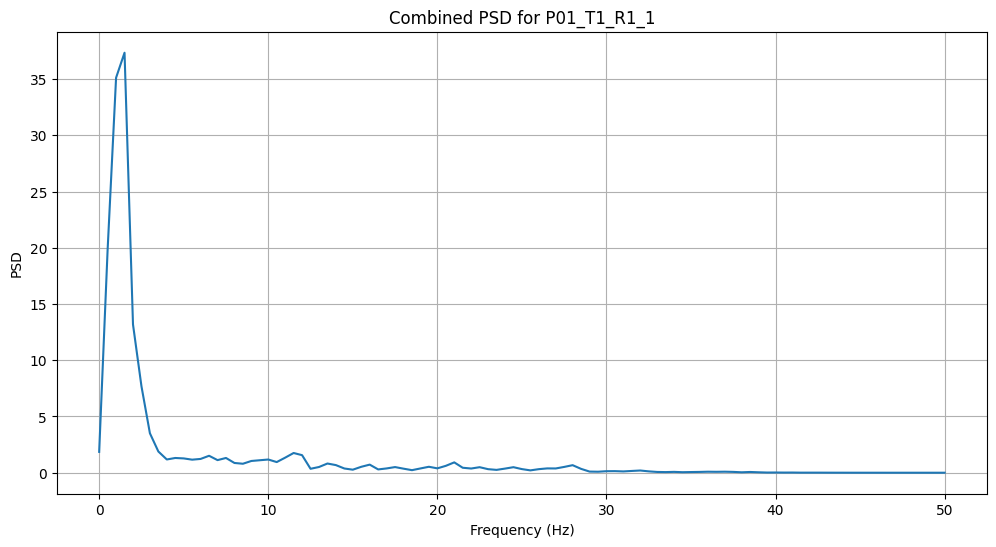

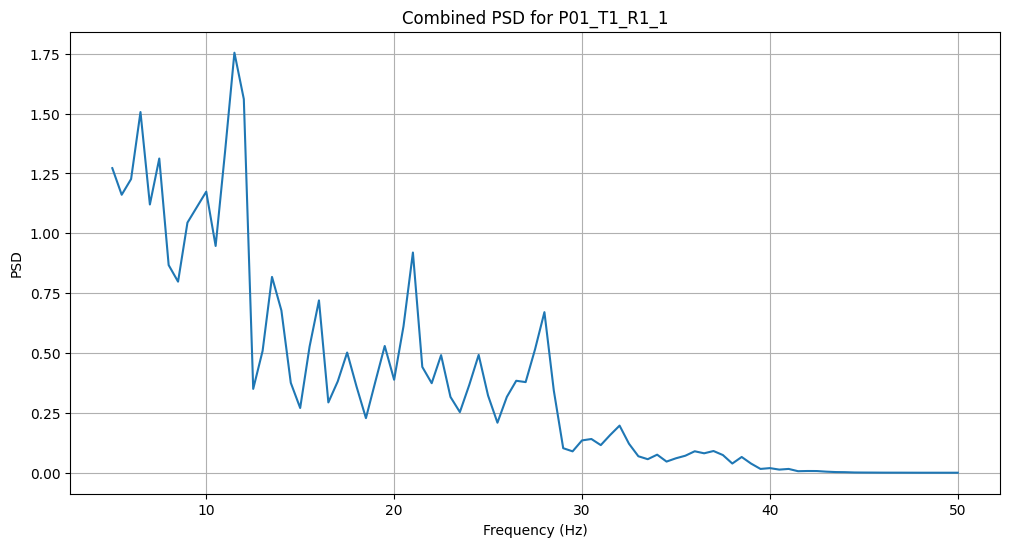

In [46]:
# Combine PSD for all channels
combined_psd_results = {}
for key, psd_data in psd_results.items():
    combined_psd = None
    for measurement, channels in psd_data.items():
        for channel, (freqs, psd) in channels.items():
            if combined_psd is None:
                combined_psd = np.zeros_like(psd)
            combined_psd += psd
    combined_psd_results[key] = (freqs, combined_psd / len(channels))

# Plot combined PSD for all channels
for key, (freqs, combined_psd) in combined_psd_results.items():
    if key == "P01_T1_R1_1":  # Adjust the condition as needed
        # Exclude frequencies below 5 Hz and above 50 Hz
        freqs_filtered = freqs[(freqs <= 50)]
        combined_psd_filtered = combined_psd[(freqs <= 50)]
        plt.figure(figsize=(12, 6))
        plt.title(f'Combined PSD for {key}')
        plt.plot(freqs_filtered, combined_psd_filtered)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.grid(True)
        plt.show()

# # Plot PSD for each channel separately
# for key, psd_data in psd_results.items():
#     if key == "P01_T1_R1_1":  # Adjust the condition as needed
#         plt.figure(figsize=(12, 6))
#         plt.title(f'PSD for {key}')
#         for measurement, channels in psd_data.items():
#             for channel, (freqs, psd) in channels.items():
#                 # Exclude frequencies above 50 Hz
#                 freqs_filtered = freqs[freqs <= 50]
#                 psd_filtered = psd[:len(freqs_filtered)]
#                 # Convert PSD to a linear scale (0 to 100)
#                 psd_linear = 100 * (psd_filtered / np.max(psd_filtered))
#                 plt.plot(freqs_filtered, psd_linear, label=f'{measurement}: {channel}')
#         plt.xlabel('Frequency (Hz)')
#         plt.ylabel('PSD (0-100 scale)')
#         plt.legend()
#         plt.grid(True)
#         plt.show()

# Plot PSD for all channels
for key, (freqs, combined_psd) in combined_psd_results.items():
    if key == "P01_T1_R1_1":  # Adjust the condition as needed
        # Exclude frequencies below 5 Hz and above 50 Hz
        freqs_filtered = freqs[(freqs <= 50)]
        combined_psd_filtered = combined_psd[(freqs <= 50)]
        plt.figure(figsize=(12, 6))
        plt.title(f'Combined PSD for {key}')
        plt.plot(freqs_filtered, combined_psd_filtered)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.grid(True)
        plt.show()

# Plot combined PSD for all channels
for key, (freqs, combined_psd) in combined_psd_results.items():
    if key == "P01_T1_R1_1":  # Adjust the condition as needed
        # Exclude frequencies below 5 Hz and above 50 Hz
        freqs_filtered = freqs[(freqs >= 5) & (freqs <= 50)]
        combined_psd_filtered = combined_psd[(freqs >= 5) & (freqs <= 50)]
        plt.figure(figsize=(12, 6))
        plt.title(f'Combined PSD for {key}')
        plt.plot(freqs_filtered, combined_psd_filtered)
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('PSD')
        plt.grid(True)
        plt.show()